# Prerequisites

- Understanding of the classifiers we have discussed in class

# Imports, Loading Functions, and Downloading Data

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB 
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

In [ ]:
"""
Options for noisy: "loud", "quiet", and other. Any other value prints nothing (silent).
"""
# Start by defining a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

# Then define a function that trains a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud', labels=[]):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet' and fold_num == 0:
        print(f"{classifier_name}: Fold {fold_num}", end = '')
    elif noisy == 'quiet':
        print(f'...{fold_num}', end ='')
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, labels).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

# Then define a function to evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud', labels=[]):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy, labels=labels)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics

#Dont worry about these two lines
# Then define a function to compare different classifiers
def compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud', labels=[]):
    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle)


    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy, labels=labels)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet': 
            print()
            print(f"Average {metric_to_optimize}: {optimization_metric_avg:.3f}")
            print('-------------')
    # Return our results
    return best, best_name, classifier_comparison
    

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1YHCYjo69dGYhkBcdft6u6xEqUH6GnU02' -O compas.csv

--2022-03-28 15:55:17--  https://drive.google.com/uc?export=download&id=1YHCYjo69dGYhkBcdft6u6xEqUH6GnU02
Resolving drive.google.com (drive.google.com)... 142.250.141.113, 142.250.141.102, 142.250.141.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/83kselaq5r5ggobe8s275ck5196895qm/1648482900000/09640029349513786515/*/1YHCYjo69dGYhkBcdft6u6xEqUH6GnU02?e=download [following]
--2022-03-28 15:55:18--  https://doc-0o-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/83kselaq5r5ggobe8s275ck5196895qm/1648482900000/09640029349513786515/*/1YHCYjo69dGYhkBcdft6u6xEqUH6GnU02?e=download
Resolving doc-0o-b0-docs.googleusercontent.com (doc-0o-b0-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-0o-b0-docs.googleusercontent.com (doc-0o-b0

# Getting to know the data (COMPAS)
Before we do anything else today, let's get acquainted with this new dataset. COMPAS is a dataset on how well an algorithm predicts recidivism - the tendency of a convicted criminal to reoffend.

COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed crimes or violent crimes after 2 years). The pattern of mistakes, as measured by precision/sensitivity is notable.

Data contains variables used by the COMPAS algorithm in scoring defendants, along with their outcomes within 2 years of the decision, for over 10,000 criminal defendants in Broward County, Florida. 

[More on the data](https://www.kaggle.com/danofer/compass#cox-violent-parsed.csv)

In [ ]:
# First lets load COMPAS and perform some preprocessing of the table
compas = pd.read_csv("compas.csv")
compas = compas.loc[compas.days_b_screening_arrest < 30]
compas = compas.loc[compas.days_b_screening_arrest > -30]
compas = compas.loc[compas.c_charge_degree != "O"]

# Summary statistics of compas data
compas["in_date"] = compas["c_jail_in"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
compas["out_date"] = compas["c_jail_out"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
compas["length_of_stay"] = compas["out_date"] - compas["in_date"]

# After processing, we have 6159 samples of 56 features
print(compas.shape)

# Let's also look at the raw data
compas.head()

(6159, 56)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,in_date,out_date,length_of_stay
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,2014-07-07,2014-07-14,0,0,327,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,0 days 23:37:38
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-01-26,2013-02-05,0,9,159,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,10 days 01:51:26
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,2013-06-16,2013-06-16,4,0,63,0,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1 days 02:03:30
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,2013-11-30,2013-12-01,0,1,853,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,1 days 07:38:38
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2014-03-31,2014-04-18,14,5,40,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,6 days 07:10:06


In [ ]:
# Let's see the distribution of the score_test column
print(compas.score_text.value_counts())

print(compas.decile_score.value_counts())

Low       3414
Medium    1604
High      1141
Name: score_text, dtype: int64
1     1283
2      820
4      665
3      646
5      581
6      527
7      496
8      419
9      418
10     304
Name: decile_score, dtype: int64


Let's also get some summary statistics to better understand the data. In the following cells we will briefly explore these relations:

- The distribution of race in the data
- The distribution of gender in the data
- The distribution of recidivism outcomes in the data

In [ ]:
print("Distribution of Race")
print(compas.race.value_counts() / len(compas))
print()

print("Distribution of Gender")
print(compas.sex.value_counts() / len(compas))
print()

print("Distrubtion of Recidivism Outcomes")
print(compas.two_year_recid.value_counts() / len(compas))
print()

Distribution of Race
African-American    0.515019
Caucasian           0.340153
Hispanic            0.082481
Other               0.055528
Asian               0.005033
Native American     0.001786
Name: race, dtype: float64

Distribution of Gender
Male      0.810034
Female    0.189966
Name: sex, dtype: float64

Distrubtion of Recidivism Outcomes
0    0.544894
1    0.455106
Name: two_year_recid, dtype: float64



Next, let's get some quick statistics on the length of stay of the average defendant; this will come into play again later in the notebook.

# Fairness Auditing

One of the main goals of today is to get you thinking about the dangers of using machine learning -- especially in tasks that have huge human impact. Machine models are almost always imperfect, as they are filled with the biases of the data they are trained on and the people who develop them. It is important that we take care to make sure the models that we develop or train are providing positive value to the world and are not doing harm.

One of the important aspects of this is to make sure that our models are not worsening inequalities that already exist -- which is incredibly common as these inequalities are often represented in the data and the models will often exaggerate these properties as they are easy to use to improve prediction accuracy. One way that we can try to avoid introducing unfair models into a sensitive task is to perform fairness audits. 

In the next cells we will examine how the COMPAS algorithm performs significantly worse on certain groups in a way that is unfair -- and in a context that has large potential impact on a person's life. Remember, the output of this COMPAS algorithm is considered by judges before deciding whether to allow people to go on parole. 

Let's start by comparing the distributions in the decile_scores predicted by the algorithm for all African-American individuals and all Caucasian individuals in the datset. 

[Resource on Fairness](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb)

[Talk on Fairness](https://youtu.be/WC1kPtG8Iz8)

## Demographic Parity

The first definition of fairness that we could choose to use is based on distribution of scores. We can see how many members of each demographic subgroup get assigned each label from the classifier, and under this naive definition, the model is unfair if the rates are not balanced.

This is overly simplistic but it gives us a starting point for understanding our data.

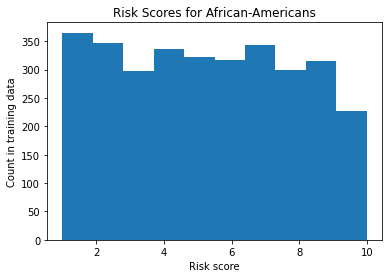

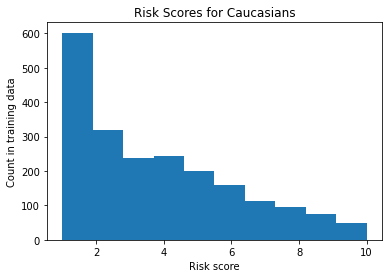

In [ ]:
plt.title("Risk Scores for African-Americans")
black = compas.loc[compas.race == "African-American"]
plt.hist(black.decile_score)
plt.xlabel("Risk score")
plt.ylabel("Count in training data")
plt.show()

plt.title("Risk Scores for Caucasians")
white = compas.loc[compas.race == "Caucasian"]
plt.hist(white.decile_score)
plt.xlabel("Risk score")
plt.ylabel("Count in training data")
plt.show()

## Prevalence 
This is complicated to analyze, though, because we don't have a good sense of pre-existing baseline distributions in the dataset. 

One simple early test is to start by counting the percentage of each race in the dataset, then seeing whether the distribution changes at each risk score.

But this doesn't tell us much about the world outside of the classifier, making it an imperfect measure.

Distribution of Race
African-American    0.515019
Caucasian           0.340153
Hispanic            0.082481
Other               0.055528
Asian               0.005033
Native American     0.001786
Name: race, dtype: float64



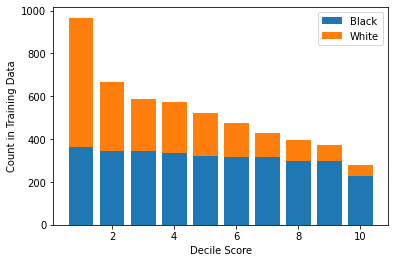

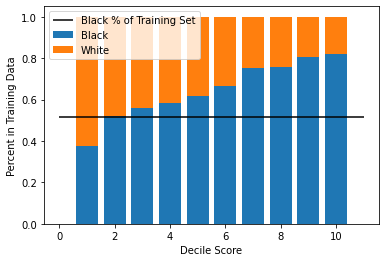

In [ ]:
print("Distribution of Race")
print(compas.race.value_counts() / len(compas))
print()

plt.bar(range(1,11), black.decile_score.value_counts())
plt.bar(range(1,11), white.decile_score.value_counts(), bottom=black.decile_score.value_counts())
plt.legend(["Black", "White"])
plt.xlabel("Decile Score")
plt.ylabel("Count in Training Data")
plt.show()

black_pcts = black.decile_score.value_counts() / (black.decile_score.value_counts() + white.decile_score.value_counts())
white_pcts = white.decile_score.value_counts() / (black.decile_score.value_counts() + white.decile_score.value_counts())

plt.bar(range(1,11), black_pcts)
plt.bar(range(1,11), white_pcts, bottom=black_pcts)
plt.hlines(0.515, 0, 11)
plt.legend(["Black % of Training Set", "Black", "White"])
plt.xlabel("Decile Score")
plt.ylabel("Percent in Training Data")
plt.show()

We can then reproduce all of the analyses above using the three-class classification task, which gives us a clearer sense of whether the model is predicting that an individual's recidivism risk is high, medium, or low.

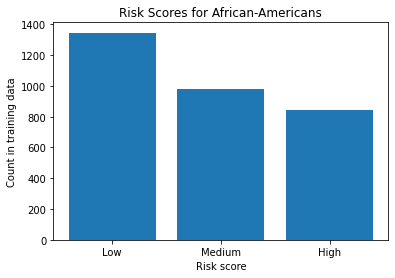

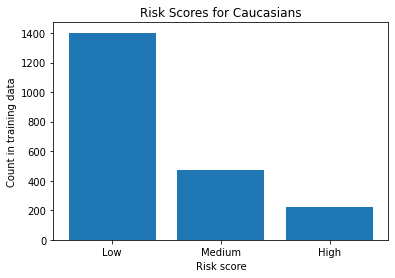

In [ ]:
plt.title("Risk Scores for African-Americans")
black = compas.loc[compas.race == "African-American"]
black_labels = black.score_text.value_counts()
plt.bar(black_labels.index, black_labels)
plt.xlabel("Risk score")
plt.ylabel("Count in training data")
plt.show()

plt.title("Risk Scores for Caucasians")
white_labels = white.score_text.value_counts()
plt.bar(white_labels.index, white_labels)
plt.xlabel("Risk score")
plt.ylabel("Count in training data")
plt.show()

Distribution of Race
African-American    0.515019
Caucasian           0.340153
Hispanic            0.082481
Other               0.055528
Asian               0.005033
Native American     0.001786
Name: race, dtype: float64



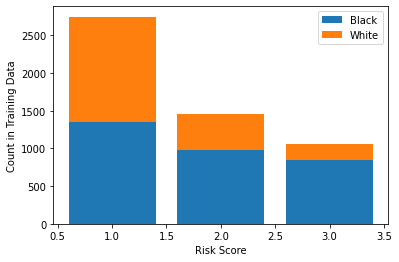

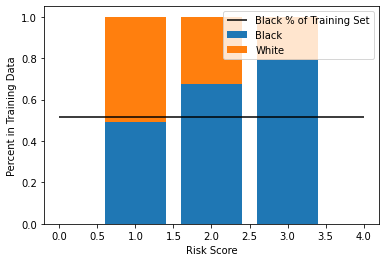

In [ ]:
print("Distribution of Race")
print(compas.race.value_counts() / len(compas))
print()

plt.bar(range(1,4), black.score_text.value_counts())
plt.bar(range(1,4), white.score_text.value_counts(), bottom=black.score_text.value_counts())
plt.legend(["Black", "White"])
plt.xlabel("Risk Score")
plt.ylabel("Count in Training Data")
plt.show()

black_pcts = black.score_text.value_counts() / (black.score_text.value_counts() + white.score_text.value_counts())
white_pcts = white.score_text.value_counts() / (black.score_text.value_counts() + white.score_text.value_counts())

plt.bar(range(1,4), black_pcts)
plt.bar(range(1,4), white_pcts, bottom=black_pcts)
plt.hlines(0.515, 0, 4)
plt.legend(["Black % of Training Set", "Black", "White"])
plt.xlabel("Risk Score")
plt.ylabel("Percent in Training Data")
plt.show()

We can already see that the distributions are uneven in our data, but this is not the end of the story. In particular, one counter-argument is that the classifier may produce racial differences in classifications, but that the predictions are justified objectively by the prevalence of recidivism in the model (that is, "black defendants really are higher risk").

Testing this hypothesis requires slightly more sophisticated analysis.


## Calibration

We can next test the model based on *calibration*. This method was the basis for the Compas developer's defense of their system and we'll see that it gives fairly good fairness results. 

Normally, this would require us to have access to the probabilities of the model. But because we have a multi-class model, we have a metric for the model to be "partially" correct based just on its observed outputs, without direct access to the model internals. We can therefore measure the likelihood of a predicted future event and whether the model's accuracy goes up as its confidence or risk score gets higher. 

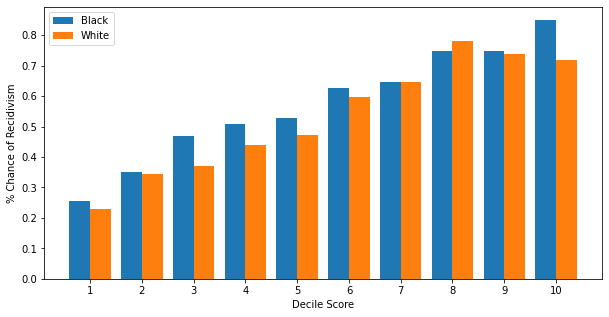

In [ ]:
# Model calibration - as the risk score predicted by the model goes up, 
# does the actual risk of recidivism go up for different subgroups at the
# same rate, or does it differ?
race_probs = []
for race in [black, white]:
    probs = []
    for score in range(1,11):
        subset = race.loc[race.decile_score == score]
        recid = subset.loc[subset.is_recid==1]
        prob_recid = len(recid) / len(subset)
        probs.append(prob_recid)
    race_probs.append(probs)

fig = plt.gcf()
fig.set_size_inches(10,5)
plt.bar(range(1,11), race_probs[0], align='edge', width=-.4)
plt.bar(range(1,11), race_probs[1], align='edge', width=.4)
plt.xlabel("Decile Score")
plt.xticks(ticks=range(1,11), labels=range(1,11))
plt.ylabel("% Chance of Recidivism")
plt.legend(["Black", "White"])
plt.show()

Separately, though we won't spend much time on this attribute during this class, we can also perform all of these same tests on sex instead of race. We see below, for instance, that while the model is calibrated well by race it actually is not by sex, which is less discussed in the literature on COMPAS.

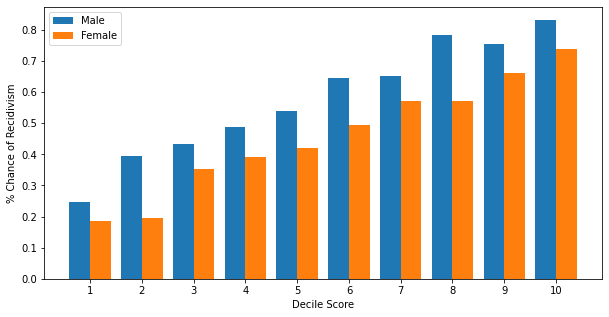

In [ ]:
male = compas.loc[compas.sex == "Male"]
female = compas.loc[compas.sex == "Female"]

sex_probs = []
for sex in [male, female]:
    probs = []
    for score in range(1,11):
        subset = sex.loc[sex.decile_score == score]
        recid = subset.loc[subset.is_recid==1]
        prob_recid = len(recid) / len(subset)
        probs.append(prob_recid)
    sex_probs.append(probs)

fig = plt.gcf()
fig.set_size_inches(10,5)
plt.bar(range(1,11), sex_probs[0], align='edge', width=-.4)
plt.bar(range(1,11), sex_probs[1], align='edge', width=.4)
plt.xlabel("Decile Score")
plt.xticks(ticks=range(1,11), labels=range(1,11))
plt.ylabel("% Chance of Recidivism")
plt.legend(["Male", "Female"])
plt.show()

These results show that the model is far more likely to miss high-risk female defendants, who have disproportionately high likelihood of rearrest when receiving a low risk score (this balances out at the very top end of the scale).

## Predictive Parity


We can look at a few more sophisticated distributions to better understand the performance of the model. Lets look at the following distributions and ask:

   - If COMPAS assigns someone the Risk score X, how likely are they to commit another crime? Does it vary across races?

To do this we test whether the model makes correct predictions. If we assume future recidivism is a "correct" label, what does our confusion matrix look like? Specifically, if we picked a risk threshold at which we said everyone with above this risk will commit a new crime, what would our accuracy be for predicting the future, and does that accuracy vary across races?

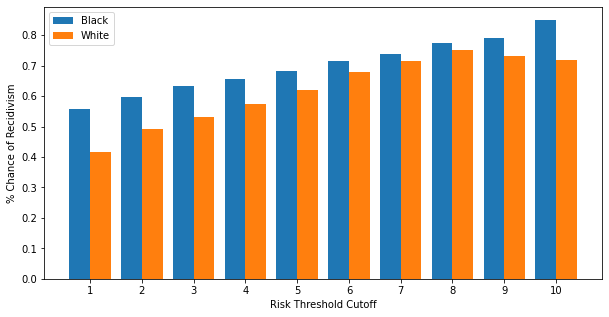

In [ ]:
# Predictive Parity
race_probs = []
for race in [black, white]:
  probs = []
  for score in range(1,11):
    subset = race.loc[race.decile_score >= score]
    recid = subset.loc[subset.is_recid==1]
    prob_recid = len(recid) / len(subset)
    probs.append(prob_recid)
  race_probs.append(probs)

fig = plt.gcf()
fig.set_size_inches(10,5)
plt.bar(range(1,11), race_probs[0], align='edge', width=-.4)
plt.bar(range(1,11), race_probs[1], align='edge', width=.4)
plt.xlabel("Risk Threshold Cutoff")
plt.xticks(ticks=range(1,11), labels=range(1,11))
plt.ylabel("% Chance of Recidivism")
plt.legend(["Black", "White"])
plt.show()

If anything, this graph would tend to suggest that the Compas system is biased against **white** defendants. At each risk threshold cutoff, white defendants at or above that threshold are less likely to commit a later crime than black defendants.

## Error Rate Parity

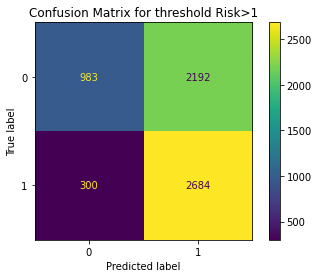

{'Accuracy': 59.538886182821884, 'Kappa': 0.20515747156413866}
---


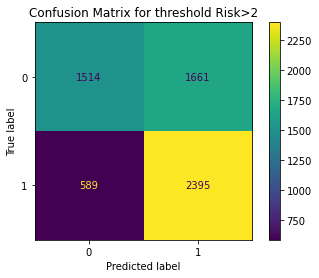

{'Accuracy': 63.46809547004384, 'Kappa': 0.2764767908697221}
---


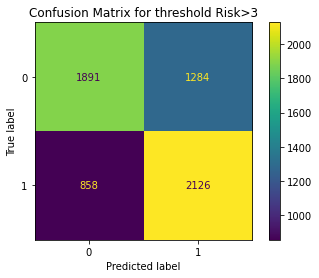

{'Accuracy': 65.22162688748173, 'Kappa': 0.30673987268156633}
---


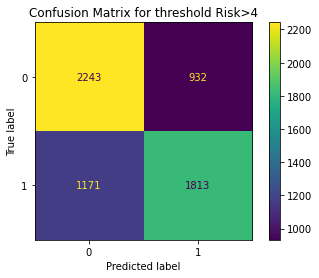

{'Accuracy': 65.85484656600099, 'Kappa': 0.31478878391827725}
---


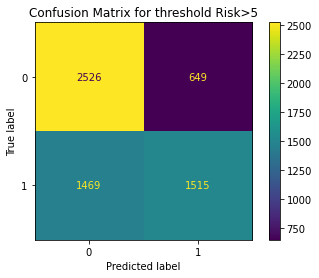

{'Accuracy': 65.61130053580126, 'Kappa': 0.3058261644186979}
---


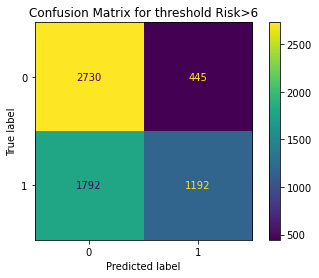

{'Accuracy': 63.67916869621691, 'Kappa': 0.26287559072828326}
---


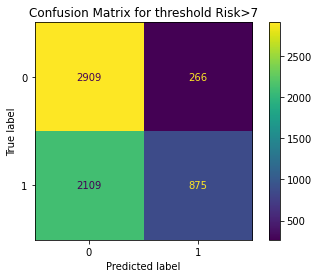

{'Accuracy': 61.4385452183796, 'Kappa': 0.21341575651227307}
---


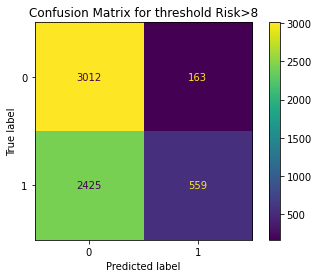

{'Accuracy': 57.980191589543765, 'Kappa': 0.13916700033559504}
---


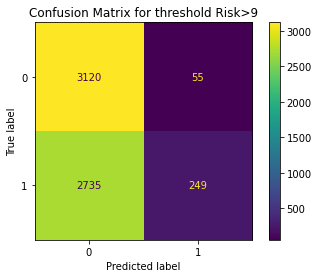

{'Accuracy': 54.70043838285436, 'Kappa': 0.06795805282124823}
---
Best threshold result: 4
Best threshold metrics: {'Accuracy': 65.85484656600099, 'Kappa': 0.31478878391827725}


In [ ]:
def find_best_threshold(df, loud=True):
  observed_outcomes = pd.Series([x==1 for x in df.is_recid])
  compas_risks = [int(x) for x in df.decile_score]

  # Set a list of metrics we want to use to compare our classifiers 
  metrics = {
      "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
      "Kappa"    : cohen_kappa_score
  }

  labels = [False, True]
  best_threshold = -1
  best_result = -1
  best_metrics = None
  metric_to_optimize = "Kappa"
  for threshold in range(1, 10):
    predicted_outcomes = [x > threshold for x in compas_risks]
    conf_matrix, model_metrics = evaluate(predicted_outcomes, observed_outcomes, metrics)
    if loud:
      ConfusionMatrixDisplay(conf_matrix).plot(values_format='.4g')
      plt.title(f"Confusion Matrix for threshold Risk>{threshold}")
      plt.show()
    print(model_metrics)
    print("---")

    if model_metrics[metric_to_optimize] > best_result:
      best_threshold = threshold
      best_result = model_metrics[metric_to_optimize]
      best_metrics = model_metrics
  print(f"Best threshold result: {best_threshold}")
  print(f"Best threshold metrics: {best_metrics}")

find_best_threshold(compas)


From this, we can see that the accuracy of the system at its best threshold (risk > 4) is 65.9%, with a kappa of 0.31. Does that differ for different subsets of the population?

In [ ]:
find_best_threshold(black, loud=False)

{'Accuracy': 61.44388398486759, 'Kappa': 0.1532497035881979}
---
{'Accuracy': 64.72257250945775, 'Kappa': 0.24620412199137276}
---
{'Accuracy': 65.29003783102144, 'Kappa': 0.2752093201639695}
---
{'Accuracy': 65.13240857503153, 'Kappa': 0.2901867729346773}
---
{'Accuracy': 64.53341740226986, 'Kappa': 0.2949490016074807}
---
{'Accuracy': 61.979823455233294, 'Kappa': 0.26121322705790195}
---
{'Accuracy': 58.79571248423707, 'Kappa': 0.2183945751832128}
---
{'Accuracy': 54.12988650693569, 'Kappa': 0.14762930556848342}
---
{'Accuracy': 49.21185372005044, 'Kappa': 0.07608376496862002}
---
Best threshold result: 5
Best threshold metrics: {'Accuracy': 64.53341740226986, 'Kappa': 0.2949490016074807}


In [ ]:
find_best_threshold(white, loud=False)

{'Accuracy': 57.13603818615752, 'Kappa': 0.19943982788026515}
---
{'Accuracy': 61.909307875894996, 'Kappa': 0.2530934025283338}
---
{'Accuracy': 64.82100238663485, 'Kappa': 0.28371881783207353}
---
{'Accuracy': 66.20525059665871, 'Kappa': 0.2837233290451189}
---
{'Accuracy': 66.73031026252984, 'Kappa': 0.27038170906407244}
---
{'Accuracy': 65.25059665871122, 'Kappa': 0.21619857645758922}
---
{'Accuracy': 63.67541766109785, 'Kappa': 0.16372003338206365}
---
{'Accuracy': 61.09785202863962, 'Kappa': 0.0883566686902566}
---
{'Accuracy': 59.379474940334134, 'Kappa': 0.0344131911816874}
---
Best threshold result: 4
Best threshold metrics: {'Accuracy': 66.20525059665871, 'Kappa': 0.2837233290451189}


We find that by this metric of error rate parity, defined based on kappa and measuring a correct prediction based on the risk score's ability to predict future re-arrest, there is no disparity! Our black population has a kappa of 0.29 and our white population has a kappa of 0.28, virtually indistinguishable.

If we stopped here, we would make the claim that this model is fair - it is equally accurate on both races we're studying, and if anything is slightly more accurate in predicting recidivism among black defendants. 

## Error Balance


However, we will now look more carefully at the modes of failure -- false positives and alse negatives -- separate from one another. This will reveal a different trend in the model's predictions. 


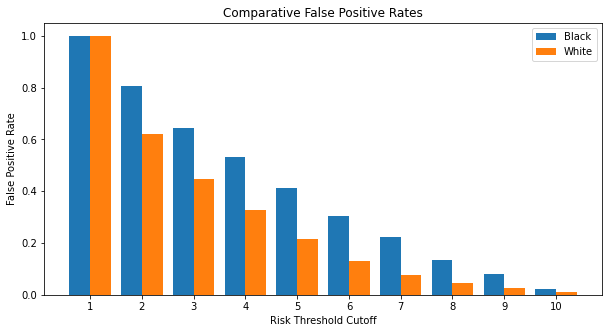

In [ ]:
# Error balance of false positives
race_probs = []
for race in [black, white]:
  probs = []
  for score in range(1,11):
    subset = race.loc[race.is_recid==0]
    false_positive = subset.loc[subset.decile_score >= score]
    false_positive_rate = len(false_positive) / len(subset)
    probs.append(false_positive_rate)
  race_probs.append(probs)

fig = plt.gcf()
fig.set_size_inches(10,5)
plt.bar(range(1,11), race_probs[0], align='edge', width=-.4)
plt.bar(range(1,11), race_probs[1], align='edge', width=.4)
plt.xlabel("Risk Threshold Cutoff")
plt.xticks(ticks=range(1,11), labels=range(1,11))
plt.ylabel("False Positive Rate")
plt.legend(["Black", "White"])
plt.title("Comparative False Positive Rates")
plt.show()

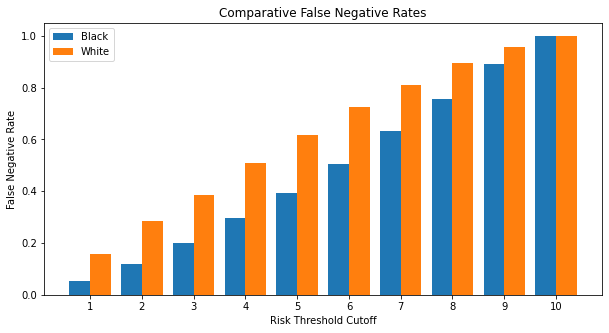

In [ ]:
# Error balance of false negatives

race_probs = []
for race in [black, white]:
  probs = []
  for score in range(1,11):
    subset = race.loc[race.is_recid==1]
    false_negative = subset.loc[subset.decile_score <= score]
    false_negative_rate = len(false_negative) / len(subset)
    probs.append(false_negative_rate)
  race_probs.append(probs)

fig = plt.gcf()
fig.set_size_inches(10,5)
plt.bar(range(1,11), race_probs[0], align='edge', width=-.4)
plt.bar(range(1,11), race_probs[1], align='edge', width=.4)
plt.xlabel("Risk Threshold Cutoff")
plt.xticks(ticks=range(1,11), labels=range(1,11))
plt.ylabel("False Negative Rate")
plt.legend(["Black", "White"])
plt.title("Comparative False Negative Rates")
plt.show()


When we do this further analysis, we see that the model has many more false positives for black defendants than it does for white defendants, and many more false negatives in the opposite direction. 

This means that, when the model fails for an African American, it tends to err on the side of guessing that they will commit another crime. In contrast, when the algorithm fails for Caucasians, it will tend to err on the side of guessing that they will *not* commit another crime. 

## Disparate Impact

We'll end this section of our analysis with a measure of _impact_ - the actual change in harm that is caused by this mismatch in error balance, even for a correctly calibrated classifier.


In [ ]:
races = {"black":black, "white":white}
race_metrics = {}

for threshold in range(1,11):
  for race_name, race in races.items():
    if race_name not in race_metrics:
      race_metrics[race_name] = {}
    positive_subset = race.loc[race.is_recid==1]
    false_positive = positive_subset.loc[positive_subset.decile_score > threshold]
    false_positive_rate = len(false_positive) / len(positive_subset)
    negative_subset = race.loc[race.is_recid==0]
    false_negative = negative_subset.loc[negative_subset.decile_score <= threshold]
    false_negative_rate = len(false_negative) / len(negative_subset)
    print(f"At threshold {threshold} and race {race_name}, FPR={false_positive_rate:.3f}, FNR={false_negative_rate:.3f}")
    race_metrics[race_name][threshold] = {
        "FPR":false_positive_rate,
        "FNR":false_negative_rate
    }


At threshold 1 and race black, FPR=0.947, FNR=0.194
At threshold 1 and race white, FPR=0.841, FNR=0.379
At threshold 2 and race black, FPR=0.879, FNR=0.354
At threshold 2 and race white, FPR=0.715, FNR=0.551
At threshold 3 and race black, FPR=0.800, FNR=0.467
At threshold 3 and race white, FPR=0.614, FNR=0.673
At threshold 4 and race black, FPR=0.703, FNR=0.586
At threshold 4 and race white, FPR=0.491, FNR=0.784
At threshold 5 and race black, FPR=0.607, FNR=0.694
At threshold 5 and race white, FPR=0.384, FNR=0.870
At threshold 6 and race black, FPR=0.494, FNR=0.778
At threshold 6 and race white, FPR=0.275, FNR=0.922
At threshold 7 and race black, FPR=0.369, FNR=0.864
At threshold 7 and race white, FPR=0.191, FNR=0.955
At threshold 8 and race black, FPR=0.242, FNR=0.919
At threshold 8 and race white, FPR=0.105, FNR=0.972
At threshold 9 and race black, FPR=0.109, FNR=0.976
At threshold 9 and race white, FPR=0.041, FNR=0.989
At threshold 10 and race black, FPR=0.000, FNR=1.000
At threshol

To measure the impact of this gap, we need to not just look at the error rate but also at the real-world impact of a misclassification. We'll use a value representing the additional prison sentence that would be added on for a high-risk defendant, compared to a low-risk prediction.

These numbers are not available in COMPAS; however, some estimates are present in the research literature, suggesting values for misdemeanor crimes at 2 months, and for felonies at 6 months. Obviously, these numbers are subject to change and if we had more information, we could change them. We will assign them to variables which we can update if we learn more information in the future.

In [ ]:
misdemeanor_penalty = 2
felony_penalty = 6

for threshold in range(1,11):
  print(f"At risk threshold {threshold}")
  for race_name, race in races.items():
    cumulative_harm = 0
    for row in range(len(race)):
      defendant = race.iloc[row]
      if defendant.decile_score >= threshold: # and defendant.is_recid == 0:
        if defendant.c_charge_degree == "M":
          cumulative_harm += misdemeanor_penalty*race_metrics[race_name][threshold]["FPR"]
        if defendant.c_charge_degree == "F":
          cumulative_harm += felony_penalty*race_metrics[race_name][threshold]["FPR"]

    print(f"   For {race_name} defendants, cumulative harm from false positives:")
    print(f"      {cumulative_harm:.1f} months across {len(race)} defendants.")
    print(f"      Average {cumulative_harm/len(race):.1f} additional months per defendant.")


At risk threshold 1
   For black defendants, cumulative harm from false positives:
      14325.6 months across 3172 defendants.
      Average 4.5 additional months per defendant.
   For white defendants, cumulative harm from false positives:
      7689.8 months across 2095 defendants.
      Average 3.7 additional months per defendant.
At risk threshold 2
   For black defendants, cumulative harm from false positives:
      11911.8 months across 3172 defendants.
      Average 3.8 additional months per defendant.
   For white defendants, cumulative harm from false positives:
      4916.2 months across 2095 defendants.
      Average 2.3 additional months per defendant.
At risk threshold 3
   For black defendants, cumulative harm from false positives:
      9659.2 months across 3172 defendants.
      Average 3.0 additional months per defendant.
   For white defendants, cumulative harm from false positives:
      3387.9 months across 2095 defendants.
      Average 1.6 additional months per d

# Training a risk classifier

Now lets try to extend our analysis away from visualizations by training some models of our own. One way we can understand how related two variables are is to train a classifier that tries to identify the value of one variable based on the value of the other. If a classifier can easily get high accuracy, then this indicates that the variables are highly related. However, the opposite is not true. In general, it is very difficult to really prove definitively that there is little relation between two variables. However, we can show that there is at least some significant nuance to the relationship if a simple classifier can not relate them easily.

## Predicting decile score

Our first test is whether we can predict the decile score based only on simple, highly visible, and protected attributes like sex, age, race, and prior convictions. 

In [ ]:
X = compas
y = compas.decile_score
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

In [ ]:

classifiers = { 
    "Multinomial NB": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVM": LinearSVC(),
    "Random Forests": RandomForestClassifier()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score,
    "QWK"      : lambda y,y_pred: cohen_kappa_score(y, y_pred, weights="quadratic")
}

# Choose a metric to optimize over
metric_to_optimize = 'QWK'
X_train['result'] = y_train
digits = [str(i) for i in range(0,10)]


In [ ]:
# Predict decile score based on easily observable features

# Pick features to use
protected_features = ["sex", "age", "race"]

feature_set = protected_features 

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, X_train, feature_set, "decile_score", labels=digits, noisy = 'quiet', folds=5)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Multinomial NB: Fold 0...1...2...3...4
Average QWK: 0.317
-------------
Decision Tree: Fold 0...1...2...3...4
Average QWK: 0.275
-------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4
Average QWK: 0.372
-------------


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...4
Average QWK: 0.266
-------------
Random Forests: Fold 0...1...2...3...4
Average QWK: 0.279
-------------
Best classifier is: Logistic Regression 
With K=0.372.


This brief evaluation results in a low but nontrivial kappa, showing that the features used in the COMPAS system are indeed more nuanced than this, but that these protected features do have some predictive power on the recidivism scores. Let's compare this to a model trained on just metadata features as well as one trained on both protected and metadata features.

In [ ]:
# Predict decile score based on easily observable features

# Pick features to use
metadata_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree", "c_charge_desc"]

feature_set = metadata_features

digits = [str(i) for i in range(0,10)]
# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, X_train, feature_set, "decile_score", labels=digits, noisy = 'quiet', folds=5)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Multinomial NB: Fold 0...1...2...3...4
Average QWK: 0.478
-------------
Decision Tree: Fold 0...1...2...3...4
Average QWK: 0.418
-------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4
Average QWK: 0.451
-------------


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...4
Average QWK: 0.426
-------------
Random Forests: Fold 0...1...2...3...4
Average QWK: 0.429
-------------
Best classifier is: Multinomial NB 
With K=0.478.


In [ ]:
# Predict decile score based on easily observable features

# Pick features to use
protected_features = ["sex", "age", "race"]
metadata_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree", "c_charge_desc"]

feature_set = protected_features + metadata_features

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, X_train, feature_set, "decile_score", labels=digits, noisy = 'quiet', folds=5)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Multinomial NB: Fold 0...1...2...3...4
Average QWK: 0.560
-------------
Decision Tree: Fold 0...1...2...3...4
Average QWK: 0.547
-------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4
Average QWK: 0.627
-------------


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...4
Average QWK: 0.292
-------------
Random Forests: Fold 0...1...2...3...4
Average QWK: 0.542
-------------
Best classifier is: Logistic Regression 
With K=0.627.


We definitely see improvement in performance from using the metadata features in addition to the protected features. The protected features do contribute to the model's ability to predict the decile score quite significantly, indicating a relationship between these protected features and the scores predicted by the algorithm. 

Our results indicate a best QWK with the following feature sets:
   - Demographics alone: 0.377
   - Observable features alone: 0.482
   - Demographics + features: 0.622

So adding the demographics is definitely useful information to the model - it will use those features as part of the model's decision-making, because they improve the accuracy of replicating observed data.

## Predicting recidivism directly

Let's continue this analysis by predicting the binary **recidivism** task based on the decile score as well as predicting recidivism based on some sets of features.

In [ ]:

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'
X = compas
y = compas.is_recid
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

In [ ]:
# Predict recidivism based on decile score

feature_set = ["decile_score"]
X_train['result'] = y_train

digits = [str(i) for i in range(0,10)]
# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, X_train, feature_set, "is_recid", labels=["0", "1"], noisy = 'quiet', folds=5)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Multinomial NB: Fold 0...1...2...3...4
Average Kappa: 0.000
-------------
Decision Tree: Fold 0...1...2...3...4
Average Kappa: 0.322
-------------
Logistic Regression: Fold 0...1...2...3...4
Average Kappa: 0.330
-------------
SVM: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...1...2

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...3...4
Average Kappa: 0.330
-------------


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Random Forests: Fold 0...1...2...3...4
Average Kappa: 0.327
-------------
Best classifier is: SVM 
With K=0.330.


In [ ]:
# Predict recidivism based on only protected features

# Pick features to use
protected_features = ["sex", "age", "race"]

feature_set = protected_features 

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, X_train, feature_set, "is_recid", labels=["0", "1"], noisy = 'quiet', folds=5)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Multinomial NB: Fold 0...1...2...3...4
Average Kappa: 0.181
-------------
Decision Tree: Fold 0...1...2...3...4
Average Kappa: 0.180
-------------
Logistic Regression: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


...1...2...3...4
Average Kappa: 0.201
-------------


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM: Fold 0...1

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...2...3

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...4
Average Kappa: 0.019
-------------
Random Forests: Fold 0...1...2...3...4
Average Kappa: 0.159
-------------
Best classifier is: Logistic Regression 
With K=0.201.


In [ ]:
# Predict recidivism based on easily observable features

# Pick features to use
protected_features = ["sex", "age", "race"]
metadata_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree", "c_charge_desc"]

feature_set = protected_features + metadata_features

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, X_train, feature_set, "is_recid", labels=["0", "1"], noisy = 'quiet', folds=5)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Multinomial NB: Fold 0...1...2...3...4
Average Kappa: 0.352
-------------
Decision Tree: Fold 0...1...2...3...4
Average Kappa: 0.219
-------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4
Average Kappa: 0.337
-------------


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...4
Average Kappa: 0.221
-------------
Random Forests: Fold 0...1...2...3...4
Average Kappa: 0.289
-------------
Best classifier is: Multinomial NB 
With K=0.352.


Interestingly, COMPAS does not appear to perform much better than these simple classifiers trained on this subset of the metadata when it comes to predicting whether someone truly will commit another crime. Further, we can see that we can make a significant amount of progress towards COMPAS' performance just by using the protected features. 

This provides some more evidence that whatever models are running underneath COMPAS have similar power to the basic methods we have learned over the semester. Further, either the methods or the data do not seem adequate to well model the complex relationships involved in predicting recidivism. Therefore, it is even more likely that the model is discovering and using simple latent features -- like race -- to help its predictions even though it is not explicitly being fed racial data. 

## Feature Importance

We'll now spend a short segment on looking at individual features in our models, and seeing how to explore them and find out which features are "doing work" in our classification.

Of course, even when a feature has a low importance by these metrics, that doesn't always mean it's doing **nothing** - but this is often a good place to start.

### In Trees and Forests

In [ ]:
X = compas
y = compas.is_recid
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

In [ ]:

# Pick features to use
protected_features = ["sex", "age", "race"]
metadata_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree", "c_charge_desc"]

feature_set = protected_features + metadata_features


classifier = DecisionTreeClassifier()
X_subset = pd.get_dummies(X_train.loc[:, feature_set])
model = classifier.fit(X_subset, y_train)

In [ ]:
# Decision trees give us 
feature_importances = dict(zip(X_subset.columns, model.feature_importances_))
for feature, importance in feature_importances.items():
  if importance > 0.01:
    print(f"{feature}: {importance:.3f}")

age: 0.277
juv_misd_count: 0.017
juv_other_count: 0.018
priors_count: 0.187
sex_Female: 0.018
sex_Male: 0.015
race_African-American: 0.027
race_Caucasian: 0.027
race_Hispanic: 0.014
race_Other: 0.016
c_charge_degree_M: 0.010
c_charge_desc_Battery: 0.015
c_charge_desc_Grand Theft in the 3rd Degree: 0.016
c_charge_desc_Possession of Cocaine: 0.016
c_charge_desc_arrest case no charge: 0.019


In [ ]:
# Pick features to use
protected_features = ["sex", "age", "race"]
metadata_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree", "c_charge_desc"]

feature_set = protected_features + metadata_features


classifier = RandomForestClassifier()
X_subset = pd.get_dummies(X_train.loc[:, feature_set])
model = classifier.fit(X_subset, y_train)

importances = [dict(zip(X_subset.columns, tree.feature_importances_)) for tree in model.estimators_]

In [ ]:
threshold = 0.01
for feature in X_subset.columns:
  included = 0
  for tree in importances:
    if tree[feature] > threshold:
      included += 1
  if included > 0:
    print(f"{feature} included in {included}/100 trees")

age included in 100/100 trees
juv_fel_count included in 63/100 trees
juv_misd_count included in 100/100 trees
juv_other_count included in 100/100 trees
priors_count included in 100/100 trees
sex_Female included in 56/100 trees
sex_Male included in 56/100 trees
race_African-American included in 87/100 trees
race_Caucasian included in 70/100 trees
race_Hispanic included in 27/100 trees
race_Other included in 9/100 trees
c_charge_degree_F included in 25/100 trees
c_charge_degree_M included in 23/100 trees
c_charge_desc_Battery included in 30/100 trees
c_charge_desc_Burglary Unoccupied Dwelling included in 1/100 trees
c_charge_desc_DUI Property Damage/Injury included in 1/100 trees
c_charge_desc_Driving While License Revoked included in 3/100 trees
c_charge_desc_Felony Driving While Lic Suspd included in 2/100 trees
c_charge_desc_Felony Petit Theft included in 1/100 trees
c_charge_desc_Grand Theft in the 3rd Degree included in 58/100 trees
c_charge_desc_Pos Cannabis W/Intent Sel/Del includ

### In Regressions

Scikit-learn directly exposes coefficients from our logistic regressions as a variable that we can access and align to our feature names.

In [ ]:
# Pick features to use
protected_features = ["sex", "age", "race"]
metadata_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree", "c_charge_desc"]

feature_set = protected_features + metadata_features


classifier = LogisticRegression()
X_subset = pd.get_dummies(X_train.loc[:, feature_set])
model = classifier.fit(X_subset, y_train)

coef = [x[0] for x in model.coef_.T]
coefficients = dict(zip(X_subset.columns, coef))

for feature, coefficient in coefficients.items():
  if coefficient > 0.01:
    print(f"{feature}: {coefficient}")

juv_fel_count: 0.20262220182402582
juv_misd_count: 0.1346523278149522
juv_other_count: 0.33082729874514155
priors_count: 0.15890076823921612
sex_Male: 0.30666259804967266
race_African-American: 0.18374284999014812
race_Caucasian: 0.13867999447565074
race_Hispanic: 0.022508558167023872
race_Native American: 0.09890165488102505
c_charge_degree_F: 0.1972646638891396
c_charge_degree_M: 0.05231221452862209
c_charge_desc_Agg Assault W/int Com Fel Dome: 0.10651269697773975
c_charge_desc_Aggravated Assault W/Dead Weap: 0.3257162908179807
c_charge_desc_Aide/Abet Prostitution Lewdness: 0.14931190769410763
c_charge_desc_Aiding Escape: 0.2399961203458336
c_charge_desc_Alcoholic Beverage Violation-FL: 0.10180867783579331
c_charge_desc_Assault: 0.33805180977496335
c_charge_desc_Att Tamper w/Physical Evidence: 0.1752825505440365
c_charge_desc_Attempt Armed Burglary Dwell: 0.017370746823889237
c_charge_desc_Attempted Burg/Convey/Unocc: 0.2383307826494618
c_charge_desc_Attempted Burg/struct/unocc: 0.08

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


As we increase regularization strength, we can observe the number of features receiving high weight going down, and only the strongest signals stay included in the model.

In [ ]:
# Pick features to use
protected_features = ["sex", "age", "race"]
metadata_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree", "c_charge_desc"]

feature_set = protected_features + metadata_features


classifier = LogisticRegression(penalty='l2', C=0.001)
X_subset = pd.get_dummies(X_train.loc[:, feature_set])
model = classifier.fit(X_subset, y_train)

coef = [x[0] for x in model.coef_.T]
coefficients = dict(zip(X_subset.columns, coef))

for feature, coefficient in coefficients.items():
  if coefficient > 0.01:
    print(f"{feature}: {coefficient}")

juv_fel_count: 0.014585158234739298
juv_other_count: 0.049976252142090435
priors_count: 0.1696320386168335
sex_Male: 0.04714161120073551
race_African-American: 0.03314029756294005
c_charge_degree_F: 0.030207935950457985
c_charge_desc_Poss Pyrrolidinovalerophenone: 0.010182935177252746
c_charge_desc_Possession of Cocaine: 0.026217370781044864


### Model-Agnostic Options

To test what features are useful for classification accuracy, we can run a series of experiments with each feature removed, then observe the gap between that model and the original model with all features, to see the individual impact of that one feature.

In [ ]:
def ablation_study():
  kf = StratifiedKFold(n_splits=5, shuffle=True)
  classifier = LogisticRegression()
  X_subset = pd.get_dummies(X_train.loc[:, feature_set])
  model = classifier.fit(X_subset, y_train)


  # Set a list of metrics we want to use to compare our classifiers 
  metrics = {
      "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
      "Kappa"    : cohen_kappa_score
  }

  baseline_metrics = evaluate_all_folds("baseline", classifier, X_subset, y_train, kf, metrics, noisy = 'quiet')
  print()
  ablation_results = {}
  for feature in feature_set:
    ablation_features = feature_set.copy()
    ablation_features.remove(feature)
    classifier = LogisticRegression()
    X_subset = pd.get_dummies(X_train.loc[:, ablation_features])
    ablation_metrics = evaluate_all_folds(f"No {feature}", classifier, X_subset, y_train, kf, metrics, noisy = 'quiet')
    ablation_results[feature] = ablation_metrics
    print()
  for feature in feature_set:
    diff_K = np.mean(ablation_results[feature]["Kappa"]) - np.mean(baseline_metrics["Kappa"])
    print(f"Remove {feature} K impact: {diff_K:.3f}")

ablation_study()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


baseline: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


No sex: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


No age: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


No race: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


No juv_fel_count: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


No juv_misd_count: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


No juv_other_count: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


No priors_count: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


No c_charge_degree: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


...4
No c_charge_desc: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


...1...2...3...4
Remove sex K impact: 0.014
Remove age K impact: -0.026
Remove race K impact: 0.013
Remove juv_fel_count K impact: 0.017
Remove juv_misd_count K impact: -0.002
Remove juv_other_count K impact: 0.003
Remove priors_count K impact: -0.082
Remove c_charge_degree K impact: 0.010
Remove c_charge_desc K impact: 0.028


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


What we observe is that `priors count` is actually the feature that has the strongest signal here. This appears to be a success story for race-blind classification, as the race feature was not needed. However, below we see that the `priors count` feature is, itself, correlated with race, making it an imperfect claim to "blindness".

6


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


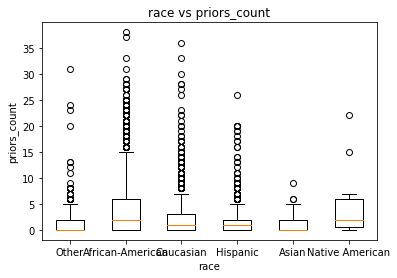

In [ ]:
vals = compas["race"].unique()
subsets = []
for v in vals:
  subsets.append(compas.loc[compas["race"] == v]["priors_count"])
print(len(subsets))
plt.boxplot(subsets)
plt.xticks(np.arange(1, len(vals)+1), vals)
plt.xlabel("race")
plt.ylabel("priors_count")
plt.title(f'{"race"} vs {"priors_count"}')
plt.show()

We see here from the ablation study that the race variable can be removed entirely from the model without losing performance. But at least one of the primary reasons for that is that the priors count feature, which is highly related to race, is a more predictive feature that accomplishes the same goal for the model.